## Ad Performance Analysis Notebook
#### This notebook contains analysis on different statstics, metrics, plots that have been used in the stakeholder presentation

In [93]:
# Analysis of Ad performance dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Data-processing

Data-analysis starts by looking at the dataset and its key statistics in order to conduct data processing and feature-engineering for the further analysis

In [94]:
# Load data
file_path = 'Ad Performance Dataset.xlsx'
app_data = pd.read_excel(file_path, sheet_name = 'App Data')
ad_data = pd.read_excel(file_path, sheet_name = 'Ad Data')

# Standardise for robustness
app_data['Date'] = pd.to_datetime(app_data['Date'])
ad_data['Date'] = pd.to_datetime(ad_data['Date'])

# Merge the datasets through left join to keep all the pre-campaign data
df = pd.merge(app_data, ad_data, on = 'Date', how = 'left')

# Data Cleaning
# We fill 'Ad spend' and 'Paid downloads' with 0 for the pre-campaign period for plotting
df['Ad spend'] = df['Ad spend'].fillna(0)
df['Paid downloads'] = df['Paid downloads'].fillna(0)

# Feature Engineering custom metrics for analysis
df['Daily Net Profit'] = df['Revenue'] - df['Ad spend']
df['Is Profit Day'] = (df['APPD (on paid downloads)'] >= 0).astype(float)

# Export cleaned data
df.to_csv('cleaned_campaign_data.csv', index = False)

In [95]:
# Find relevant stats and distinguish the two periods for analysis
campaign_df = df[df['Date'] >= pd.to_datetime('2014-10-07')].copy()
pre_campaign_df = df[df['Date'] < pd.to_datetime('2014-10-07')].copy()

# Total statistics
total_cost = campaign_df['Ad spend'].sum()
total_revenue = campaign_df['Revenue'].sum()
total_profit = total_revenue - total_cost

# Pre-campaign statistics
avg_downloads_pre = pre_campaign_df['Total downloads'].mean()
avg_organic_pre = pre_campaign_df['Organic downloads'].mean()
avg_profit_pre = pre_campaign_df['Daily Net Profit'].mean()

# Campaign statistics
avg_downloads_camp = campaign_df['Total downloads'].mean()
avg_organic_camp = campaign_df['Organic downloads'].mean()
avg_profit_camp = campaign_df['Daily Net Profit'].mean()

# Impact
impact_downloads = avg_downloads_camp / avg_downloads_pre
impact_organic = avg_organic_camp / avg_organic_pre
impact_profit = avg_profit_camp / avg_profit_pre

# 5. Print Results in a clean format
print("DAILY STATS")
print(f"Daily Downloads:      Pre: {avg_downloads_pre:.0f} | Camp: {avg_downloads_camp:,.0f} | Impact: {impact_downloads:.0f}x")
print(f"Daily Organic:        Pre: {avg_organic_pre:.0f} | Camp: {avg_organic_camp:,.0f} | Impact: {impact_organic:.0f}x")
print(f"Daily Net Profit:     Pre: ${avg_profit_pre:.2f} | Camp: ${avg_profit_camp:,.2f} | Impact: {impact_profit:.0f}x")
print("CAMPAIGN STATS")
print(f"Total Cost:          ${total_cost:,.2f}")
print(f"Total App Revenue:   ${total_revenue:,.2f}")
print(f"Net Campaign Profit: ${total_profit:,.2f}")
print(f"Avg. Cost per User:  ${campaign_df['CPI'].mean():.3f}")

DAILY STATS
Daily Downloads:      Pre: 13 | Camp: 2,268 | Impact: 180x
Daily Organic:        Pre: 13 | Camp: 855 | Impact: 68x
Daily Net Profit:     Pre: $1.08 | Camp: $111.38 | Impact: 103x
CAMPAIGN STATS
Total Cost:          $7,563.00
Total App Revenue:   $17,141.79
Net Campaign Profit: $9,578.79
Avg. Cost per User:  $0.068


In [96]:
# Understand pre-campaign and campaign lengths
print(len(campaign_df))
print(len(pre_campaign_df))


86
67


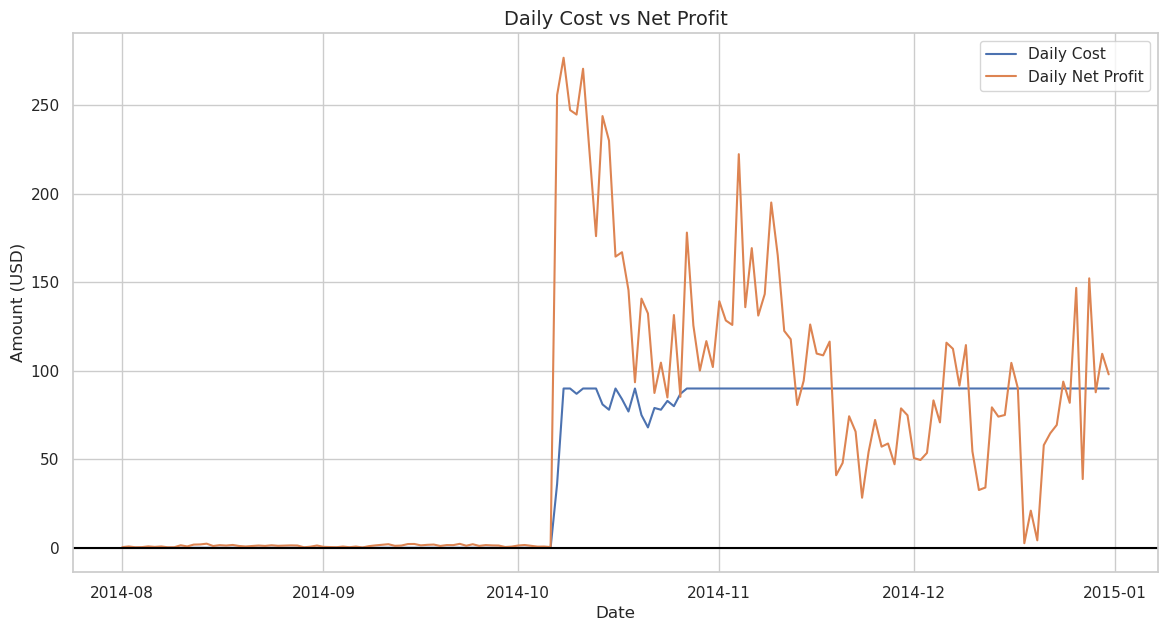

In [97]:
# Plot cost and net profit for the entire dataframe
plt.figure(figsize = (14, 7))

plt.plot(df['Date'], df['Ad spend'], label = 'Daily Cost')
plt.plot(df['Date'], df['Daily Net Profit'], label = 'Daily Net Profit')

# formatting
plt.axhline(y = 0, color = 'black')
plt.title('Daily Cost vs Net Profit', fontsize = 14)
plt.xlabel('Date')
plt.ylabel('Amount (USD)')
plt.legend()
plt.show()

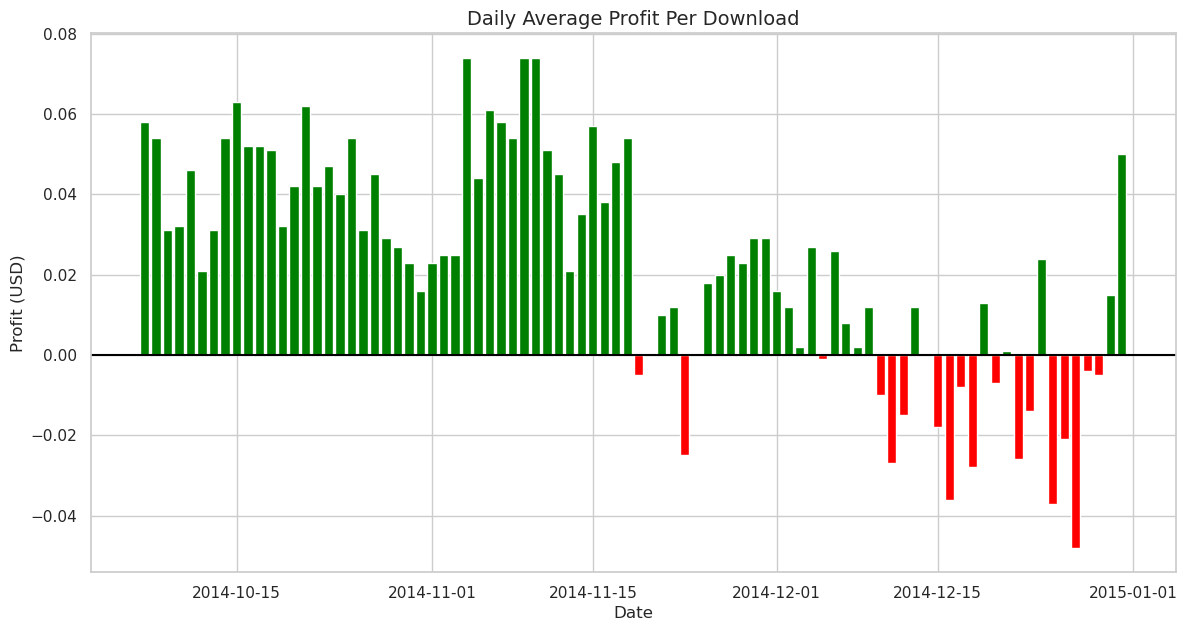

In [98]:
# APPD graph, showing direct profit per download

# Chart showing the Average Profit Per Download (APPD)
plt.figure(figsize = (14, 7))

# Create bars with conditional coloring
plt.bar(campaign_df['Date'], campaign_df['APPD (on paid downloads)'], 
        color = ['green' if x >= 0 else 'red' for x in campaign_df['APPD (on paid downloads)']])

# formatting
plt.axhline(y = 0, color = 'black')
plt.title('Daily Average Profit Per Download', fontsize = 14)
plt.ylabel('Profit (USD)')
plt.xlabel('Date')
plt.show()

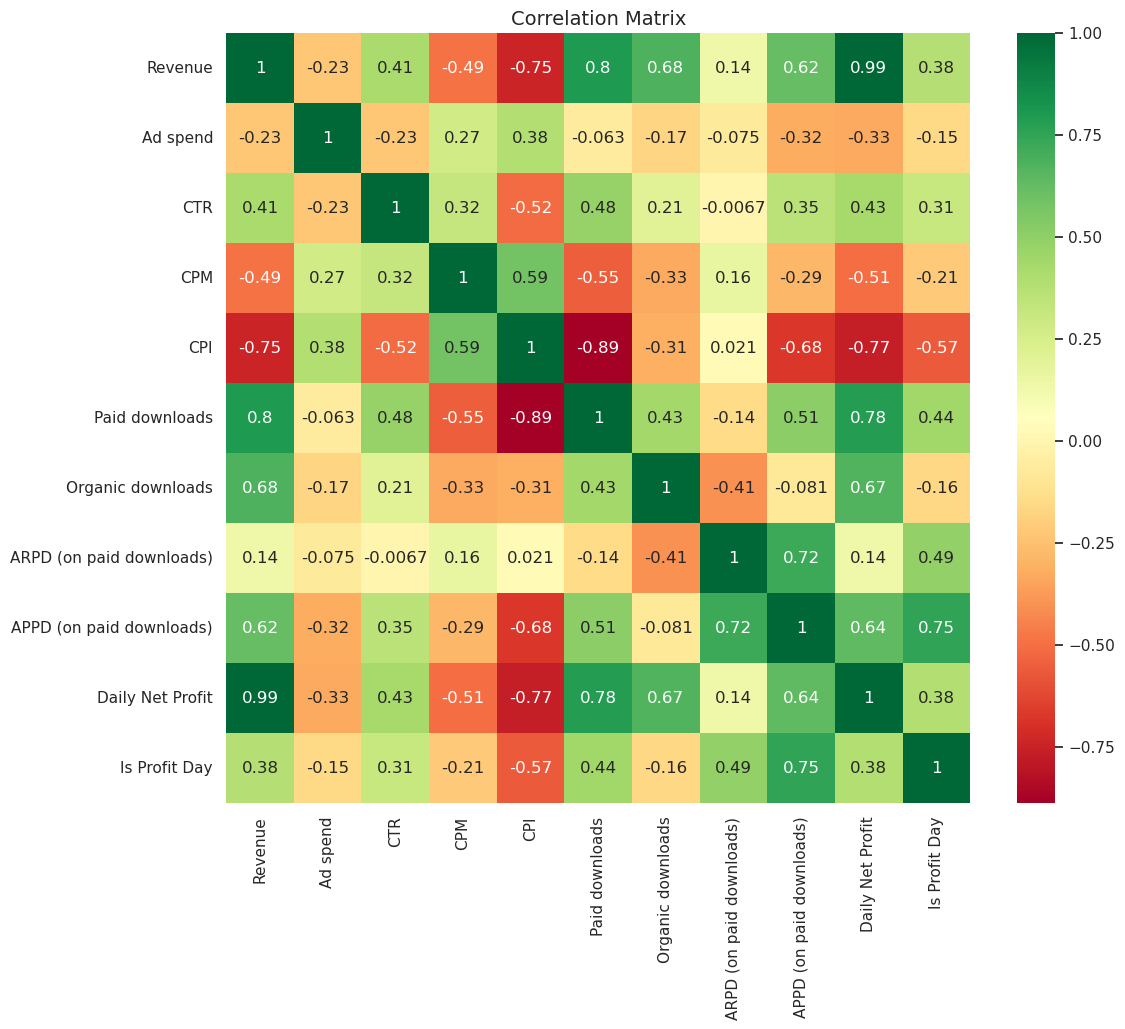

In [99]:
# Correlation matrix created to understand key parameters to analyse, 
# Red Yellow Green colouring is a simple way to distinguish the important paramenters and correlations
# Select columns to analyze
cols = [
    'Revenue', 'Ad spend', 'CTR', 'CPM', 'CPI', 
    'Paid downloads', 'Organic downloads', 
    'ARPD (on paid downloads)', 'APPD (on paid downloads)', 
    'Daily Net Profit', 'Is Profit Day'
]

# Calculate the correlation and plot
plt.figure(figsize = (12, 10))
sns.heatmap(campaign_df[cols].corr(), annot = True, cmap = 'RdYlGn')
plt.title('Correlation Matrix', fontsize = 14)
plt.show()

Probability of Profit by CPI Level
CPI level
(0.0, 0.05]     100.000000
(0.05, 0.07]     96.774194
(0.07, 0.09]     66.666667
(0.09, 0.11]     30.769231
Name: APPD (on paid downloads), dtype: float64


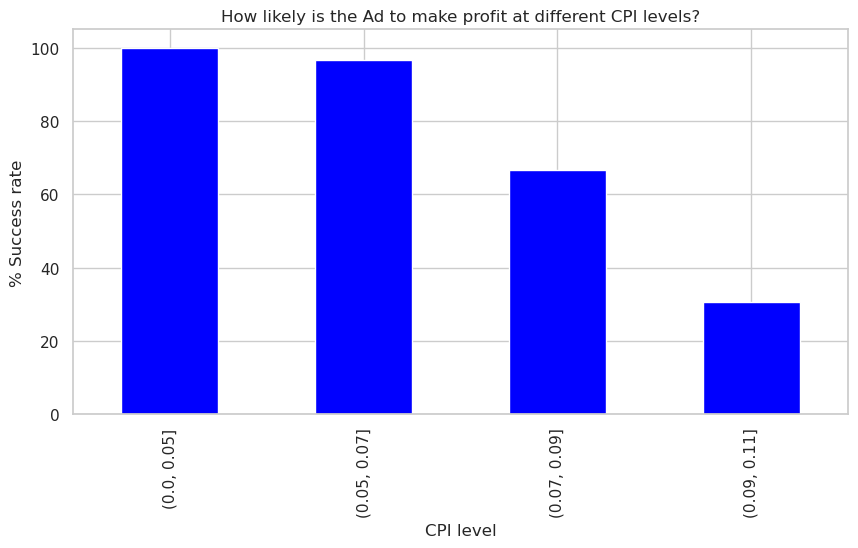

In [103]:
# CPI levels and bins used to understand different profitability levels, when cost per install is high, are advertisements worth running?

# Create brackets for CPI to calculate the probability of being profitable
campaign_df['CPI level'] = pd.cut(campaign_df['CPI'], bins = [0, 0.05, 0.07, 0.09, 0.11])

# Calculate % of days that were profitable based on APPD
success = campaign_df.groupby('CPI level', observed = True)['APPD (on paid downloads)'].apply(lambda x: (x >= 0).mean() * 100)

print("Probability of Profit by CPI Level")
print(success)

# Visualisation of the Success Rate
success.plot(kind = 'bar', color = 'blue', figsize = (10,5))
plt.title('How likely is the Ad to make profit at different CPI levels?')
plt.ylabel('% Success rate')
plt.show()

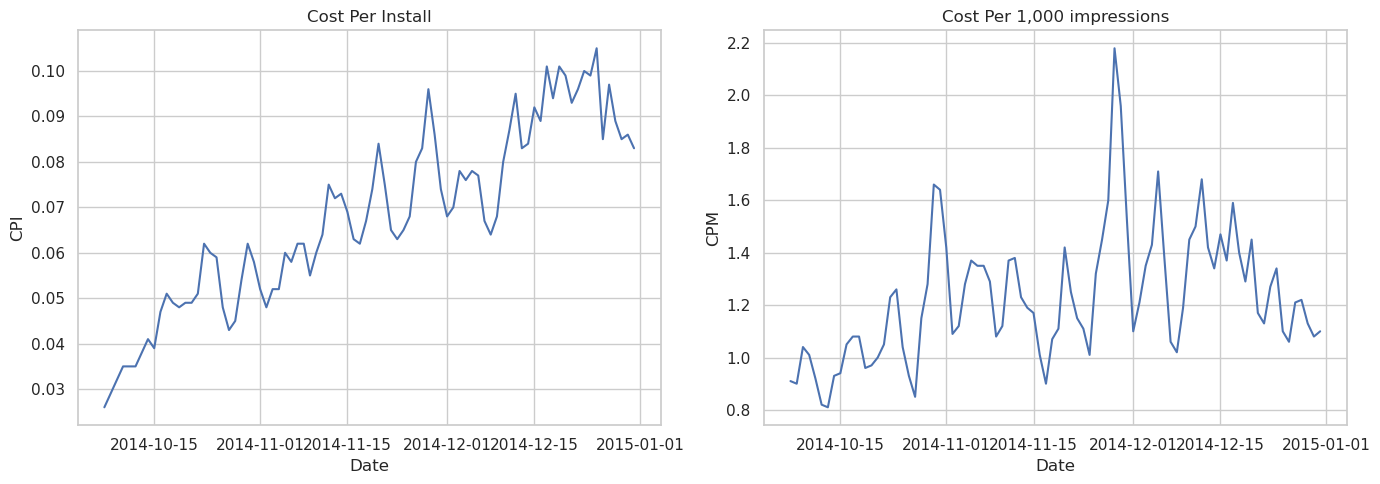

In [104]:
# Plotting CPI and CPM which are the most important directly ad specific metrics to assess

# Set theme
sns.set_theme(style = "whitegrid")

# create a grid such that plots are side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(data = campaign_df, x = 'Date', y = 'CPI', ax = axes[0]).set_title('Cost Per Install')
sns.lineplot(data = campaign_df, x = 'Date', y = 'CPM', ax = axes[1]).set_title('Cost Per 1,000 impressions')
plt.tight_layout()
plt.show()

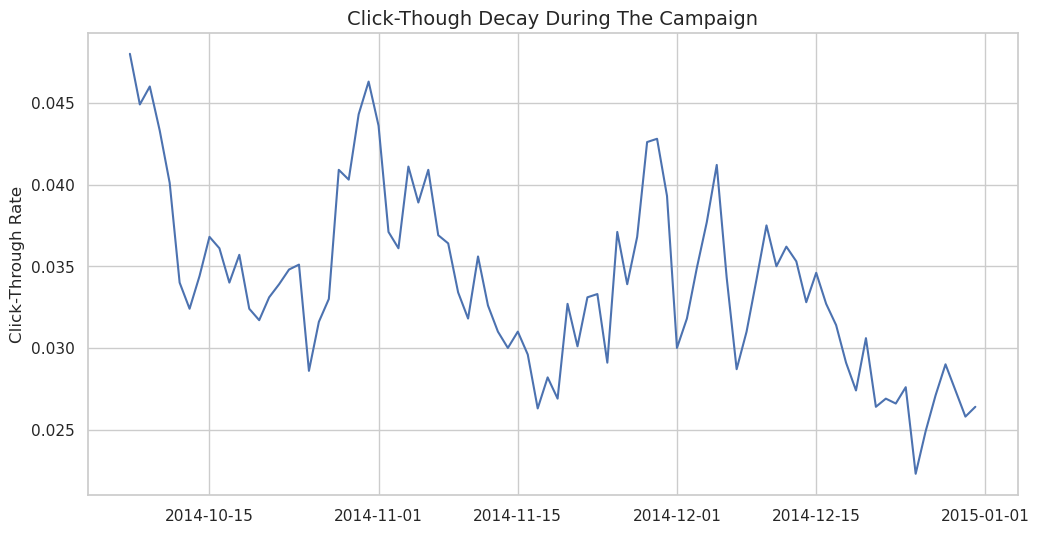

In [105]:
# Click-through rate is plotted to assess and understand how it fluctates during the campaign
# Plot CTR over time with a Trend Line
plt.figure(figsize = (12, 6))
plt.plot(campaign_df['Date'], campaign_df['CTR'])
plt.title('Click-Though Decay During The Campaign', fontsize = 14)
plt.ylabel('Click-Through Rate')
plt.show()

In [106]:
# Key Stats for click-through rate
# Overall CTR average
ctr_average = campaign_df['CTR'].mean()

# CTR average towards the end
end_avg = campaign_df['CTR'].iloc[-14:].mean()

print(f"CTR average: {ctr_average:.2%}")
print(f"Last two weeks average: {end_avg:.2%}")

CTR average: 3.40%
Last two weeks average: 2.70%


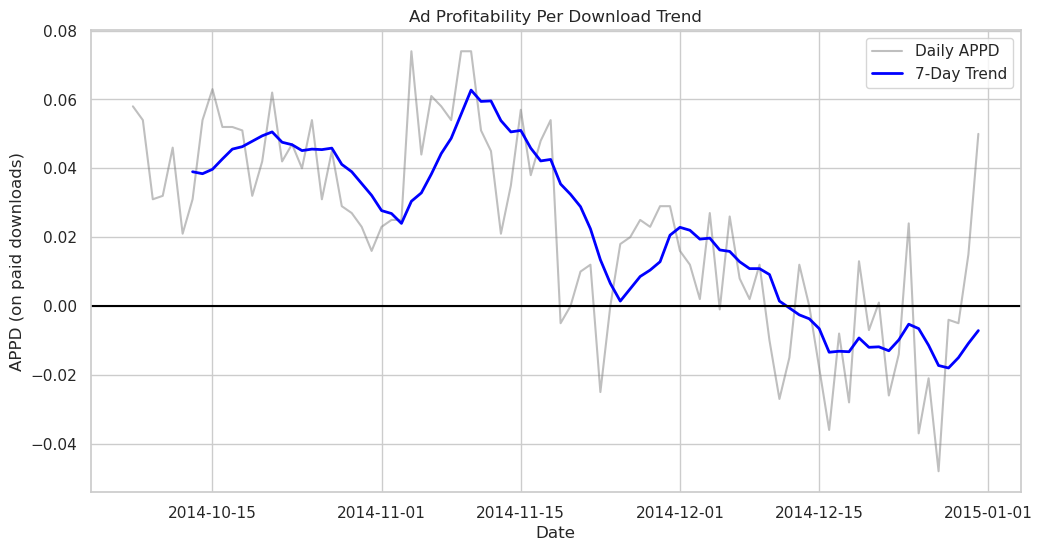

In [109]:
# Moving average for the APPD is used to create protocols for shutdown/limiting budget
# Moving avergae is a good method to reduce noise and focus on the overall trend levels

# Calculate the trend line
campaign_df['7_day_avg'] = campaign_df['APPD (on paid downloads)'].rolling(7).mean()

# Plot 
sns.set_theme(style = "whitegrid")
plt.figure(figsize = (12, 6))

sns.lineplot(data = campaign_df, x = 'Date', y = 'APPD (on paid downloads)', color = 'gray', alpha = 0.5, label = 'Daily APPD')
sns.lineplot(data = campaign_df, x = 'Date', y = '7_day_avg', color = 'blue', linewidth = 2, label = '7-Day Trend')

# add formatting
plt.axhline(y = 0, color = 'black')
plt.title('Ad Profitability Per Download Trend')
plt.show()

Average organic downloads 855.1279069767442
Average paid downloads 1412.3837209302326


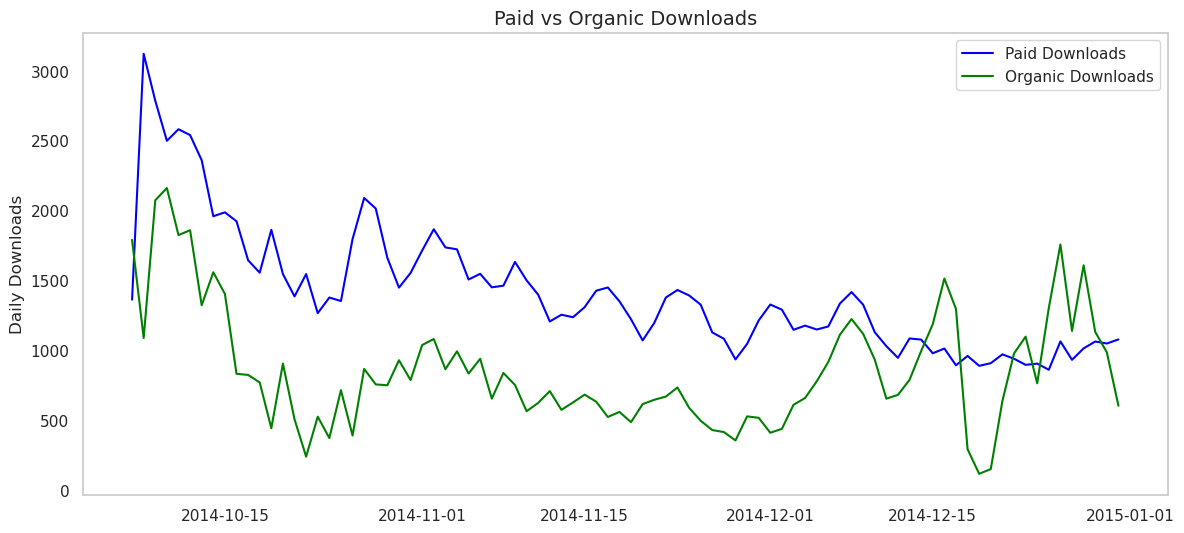

In [108]:
# Spillover is assess to understand the indirect effect of the advertisement
# This is crucial since we have seen that the APPD levels are negative and yet the app is not losing money on any day throughout the campaign

print('Average organic downloads', campaign_df['Organic downloads'].mean())
print('Average paid downloads', campaign_df['Paid downloads'].mean())
plt.figure(figsize = (14, 6))

# Plotting both trends
plt.plot(campaign_df['Date'], campaign_df['Paid downloads'], label = 'Paid Downloads', color = 'blue')
plt.plot(campaign_df['Date'], campaign_df['Organic downloads'], label = 'Organic Downloads', color = 'green')

# Formatting
plt.title('Paid vs Organic Downloads', fontsize = 14)
plt.ylabel('Daily Downloads')
plt.legend()
plt.grid()

plt.show()